# Extracting general information about the dataset

This notebook uses the graph algorithms provided by Neo4j's Graph data science library (https://neo4j.com/docs/graph-data-science/1.3/algorithms/)

It includes the following algorithms:
* Clustering: Label propagation
* Clustering: Louvain algorithm
* Centrality: PageRank algorithm
* Centrality: Betweeness centrality
* Similarity: Node similarity

First, let us connect to the database:

In [17]:
from neo4j import GraphDatabase, basic_auth
from dotenv import load_dotenv
import os

load_dotenv()

neo4jUser = os.getenv("NEO4J_USER")
neo4jPwd = os.getenv("NEO4J_PASSWORD_DS")
neo4jUrl = os.getenv("NEO4j_BOLT_DS")

driver = GraphDatabase.driver(neo4jUrl,auth=basic_auth(neo4jUser, neo4jPwd))

## Inital preparation

### The excluded papers

As discovered by the graph visualization, there is a large cluster of papers that have been considered and have been excluded. 
Unfortunately we do not have too much information on these papers other than name, journal and exclusion reation, and they account for more than 2000 nodes.

By this, they will be removed for the rest of the graph study, as they accout for 20% of the data, and we are not really interested in how they cluster or which are central in sammenheng with the rest of the nodes.

However, before they are deleted, it can be interesting to perform a influence search on just this subset of the graph, the considered papers, the exclusion reasons and the journals they are collected from.
By this, we make a projection with only these nodes, and run the page tank algorithm on that

In [18]:
import pandas as pd

label_prop_table = []
with driver.session() as session:
    session.run("""CALL gds.graph.create("excluded-papers", ["ConsideredPaper", "ExclusionReason", "SourceOrigin"],"*")""")
    res = session.run("""
        CALL gds.pageRank.stream('excluded-papers')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).name AS name, labels(gds.util.asNode(nodeId))[0] as label, score
        ORDER BY score DESC
    """)
    
    for rec in res:
        label_prop_table.append([rec["name"], rec["label"], rec["score"]])
    session.run("CALL gds.graph.drop('excluded-papers')")

pd.DataFrame(label_prop_table, columns=["Name", "Label", "Score"])

,Name,Label,Score
0,No data of interest,ExclusionReason,49.758413
1,No quantitative information,ExclusionReason,23.036321
2,Treated animals only,ExclusionReason,20.996300
3,Brain Research,SourceOrigin,18.765016
4,Neuroscience,SourceOrigin,16.799370
...,...,...,...
2575,Sema4C expression in neural stem/progenitor ce...,ConsideredPaper,0.150000
2576,The Lesion Analysis of Cholinergic Neurons in ...,ConsideredPaper,0.150000
2577,Age and lesion-induced increases of GDNF trans...,ConsideredPaper,0.150000
2578,Compacted DNA nanoparticle gene transfer of GD...,ConsideredPaper,0.150000


In [19]:
papers_page_rank = _
papers_page_rank.to_csv("..\Data/csvs/graphAnalysis/pageRank_excluded_papers.csv")
papers_page_rank.loc[papers_page_rank["Label"] == "ExclusionReason"].head(3)

,Name,Label,Score
0,No data of interest,ExclusionReason,49.758413
1,No quantitative information,ExclusionReason,23.036321
2,Treated animals only,ExclusionReason,20.996300


In [20]:
papers_page_rank.loc[papers_page_rank["Label"] == "ConsideredPaper"].head(3)

,Name,Label,Score
376,Heterogeneous distribution of polysialylated n...,ConsideredPaper,0.15
377,Biochemical and pathological study of endogeno...,ConsideredPaper,0.15
378,Effect of the weaver mutation on the expressio...,ConsideredPaper,0.15


In [21]:
papers_page_rank.loc[papers_page_rank["Label"] == "SourceOrigin"].head(5)

,Name,Label,Score
3,Brain Research,SourceOrigin,18.765016
4,Neuroscience,SourceOrigin,16.799370
7,Journal of Comparative Neurology,SourceOrigin,10.902484
9,Journal of Neuroscience,SourceOrigin,5.993746
10,Experimental Neurology,SourceOrigin,5.186248


We can see that the most common exclusion reason is "No data of interest", that all papers have the same influence (connected to the same amount of nodes), and that Brain Research has provided most excluded papers. However, the last part there is probably because it has provided most papers in total.

Now we can delete these papers.

**NB!** These nodes are deleted permanently so remember to run the script that generated the database again after if you need the original database, or run these algorithms in a Sandbox for this purpose

In [22]:
with driver.session() as session:
    session.run("""
        Match (n) WHERE n:ConsideredPaper OR n:ExclusionReason OR n:Calculation
        DETACH DELETE n
    """)


Many of the algorithms are run in the entire graph, so we create that projection now:

In [25]:
with driver.session() as session:
    session.run("CALL gds.graph.create('all-nodes', '*', '*')")

## Community detection Algorithms

Many graph representations, such as social networks, divide naturally into communities. Algorithms that discover such communities are called community detection algorithms. These algorithms can help uncover the structure of the graph and group tendencies. Communities are such that node members of a community have more relationships within the community than with nodes outside of that community. Examples of such algorithms are label propagation and the Louvain algorithm.

### Label Propagation

The label propagation finds clusters based on labels. The algorithm is iterative and propagates labels through the graph.

We run this algortihm here on the entire graph projection

In [26]:
import pandas as pd

label_prop_table = []
with driver.session() as session:
    res = session.run("""
        CALL gds.labelPropagation.stream(
            'all-nodes',
            {
              maxIterations: 5
            }
        ) 
        YIELD nodeId, communityId
        RETURN communityId, count(nodeId) AS size
        ORDER BY size DESC
        LIMIT 15
    """)
    
    for rec in res:
        label_prop_table.append([rec["communityId"], rec["size"]])

pd.DataFrame(label_prop_table, columns=["Community Id", "Size"])

,Community Id,Size
0,4911,1796
1,4912,813
2,6251,448
3,4900,359
4,13008,258
5,13023,159
6,12875,150
7,13016,94
8,13035,58
9,300,51


Next, we store the community Id to the databse

In [27]:
with driver.session() as session:
    session.run("""
        CALL gds.labelPropagation.write(
            'all-nodes',
            {
              maxIterations: 5,
              writeProperty:'community'
            }
        )
    """)

Now, we can use this community Id to investigate the largest communities.
One thing to do is visualization, but for that we need to use other tools, so for now, we can looke at the labels that are within the differnt groups and their count.

In [28]:
def get_labels_in_communities(prop, row):
    label_counts = []
    with driver.session() as session:
        res = session.run("""
            MATCH (n {%s: %d})
            RETURN DISTINCT labels(n)[0] as label, count(n) as number
            ORDER BY number
        """ % (prop, row[0]))
        
        for rec in res:
            label_counts.append([rec["label"], rec["number"]])
        print("Community:", row[0])
        return label_counts

pd.DataFrame(get_labels_in_communities("community", label_prop_table[0]), columns=["label", "number"])          
        

Community: 4911


,label,number
0,Specie,1
1,AgeCategory,5
2,Strain,8
3,Nomenclature,13
4,Distribution,17
5,Experiment,41
6,BrainRegion,62
7,BamsRegion,80
8,RegionRecord,158
9,RegionOther,195


In [29]:
pd.DataFrame(get_labels_in_communities("community", label_prop_table[1]), columns=["label", "number"])          

Community: 4912


,label,number
0,Specie,1
1,Distribution,1
2,Nomenclature,1
3,AgeCategory,5
4,Strain,13
5,Experiment,18
6,RegionOther,24
7,RegionRecord,95
8,Analysis,158
9,Specimen,190


In [15]:
pd.DataFrame(get_labels_in_communities("community", label_prop_table[2]), columns=["label", "number"])          

Community: 9804


,label,number
0,Distribution,1
1,Specie,1
2,AgeCategory,5
3,Nomenclature,6
4,BrainRegion,8
5,Strain,15
6,Analysis,16
7,Experiment,19
8,DataType,50
9,RegionOther,77


In [30]:
pd.DataFrame(get_labels_in_communities("community", label_prop_table[3]), columns=["label", "number"])          

Community: 4900


,label,number
0,Strain,1
1,Substrain,1
2,Nomenclature,5
3,BrainRegion,8
4,Experiment,10
5,RegionRecord,40
6,Specimen,48
7,RegionOther,53
8,Analysis,59
9,DataType,134


In [31]:
## The solution is "unspecified"
pd.DataFrame(get_labels_in_communities("community", label_prop_table[4]), columns=["label", "number"])          

Community: 13008


,label,number
0,Solution,1
1,LightFluorescenceMicroscopeDetail,1
2,Experiment,92
3,Specimen,164


### Louvain algortihm

The Louvain algorithm is a more advanced method for finding communities in large graphs. The algorithm detects the communities by the concept of maximum modularity.

In [32]:
import pandas as pd

louvain_table = []
with driver.session() as session:
    res = session.run("""
        CALL gds.louvain.stream('all-nodes')
        YIELD nodeId, communityId
        RETURN communityId AS louvainId, COUNT(DISTINCT nodeId) AS members
        ORDER BY members DESC
    """)
    
    for rec in res:
        louvain_table.append([rec["louvainId"], rec["members"]])

pd.DataFrame(louvain_table, columns=["Louvain Id", "Size"])

,Louvain Id,Size
0,2694,868
1,2766,377
2,2695,377
3,5158,194
4,3586,164
...,...,...
1310,5916,1
1311,5917,1
1312,5919,1
1313,5928,1


Are there any difference with intermediate communities?

In [33]:
import pandas as pd

louvain_inter_table = []
with driver.session() as session:
    res = session.run("""
        CALL gds.louvain.stream(
          'all-nodes',
          {
            includeIntermediateCommunities: true
          }
        )
        YIELD nodeId, communityId, intermediateCommunityIds
        RETURN communityId AS louvainId, COUNT(DISTINCT nodeId) AS members, intermediateCommunityIds ORDER BY members DESC
    """)
    
    for rec in res:
        louvain_inter_table.append([rec["louvainId"], rec["members"]])

pd.DataFrame(louvain_inter_table, columns=["Louvain Id", "Size"])

,Louvain Id,Size
0,2694,735
1,2766,542
2,2695,359
3,5158,192
4,3524,150
...,...,...
1341,5917,1
1342,5919,1
1343,5928,1
1344,5929,1


Yes. So what is the difference? 

Now, let's write the property to the graph for further investigation. The nodes recieve the property `louvain` that tells which community they are in and `louvainIntermediate` for the intermediate communitites.

In [34]:
with driver.session() as session:
    session.run("""
        CALL gds.louvain.write(
          'all-nodes',
          {
            writeProperty: 'louvain'
          }
        )
    """)
    session.run("""
        CALL gds.louvain.write(
          'all-nodes',
          {
            includeIntermediateCommunities: true,
            writeProperty: 'louvainIntermediate'
          }
        )
    """)

With intermediate nodes, the same groups are found, except some nodes are included in multiple groups. This provivides no new findings.

As with Label propagation, we'll find the labels that are included in the largest communitites

In [35]:
pd.DataFrame(get_labels_in_communities("louvain", louvain_table[0]), columns=["label", "number"])          

Community: 2694


,label,number
0,Specie,1
1,Distribution,2
2,AgeCategory,5
3,Strain,7
4,Nomenclature,13
5,Analysis,23
6,Experiment,24
7,BrainRegion,62
8,BamsRegion,79
9,DataType,85


In [36]:
pd.DataFrame(get_labels_in_communities("louvain", louvain_table[1]), columns=["label", "number"])          

Community: 2766


,label,number
0,CellPhenotypeCategory,1
1,Distribution,1
2,NeuralStructure,3
3,BrainRegion,15
4,RegionRecord,21
5,CellType,39
6,RegionZone,46
7,CellPhenotype,77
8,DataType,95
9,Analysis,192


In [37]:
pd.DataFrame(get_labels_in_communities("louvain", louvain_table[2]), columns=["label", "number"])          

Community: 2695


,label,number
0,Specie,1
1,Distribution,1
2,Nomenclature,1
3,AgeCategory,5
4,Strain,7
5,Experiment,18
6,RegionOther,24
7,Analysis,25
8,DataType,48
9,RegionRecord,92


In [38]:
pd.DataFrame(get_labels_in_communities("louvain", louvain_table[3]), columns=["label", "number"])          

Community: 5158


,label,number
0,Microscope,1
1,Analysis,2
2,LightFluorescenceMicroscopeDetail,189


In [39]:
pd.DataFrame(get_labels_in_communities("louvain", louvain_table[4]), columns=["label", "number"])          

Community: 3586


,label,number
0,CellType,1
1,CellGroup,1
2,CellClass,1
3,CellDescription,1
4,RegionRecord,5
5,Analysis,12
6,RegionZone,21
7,DataType,45


In [40]:
pd.DataFrame(get_labels_in_communities("louvain", louvain_table[5]), columns=["label", "number"])          

Community: 5445


,label,number
0,Software,1
1,Analysis,7
2,DataType,95


## Centrality algorithms

Centrality algorithms measure which nodes are the most influential and have an extensive impact on the graph.
There are multiple ways to measure the centrality of nodes. There are more simplistic approaches, like only counting the in- or out-degree of the nodes, and more advanced methods that take the dynamics of the connected nodes into account.

Here, we run the betweenness centrality algorithm and the PageRank algorithm

### PageRank

PageRank is a centrality algorithm that takes the influence of all the nodes into account. The algorithm works by transferring the nodes' ranking scores to the neighbor nodes proportional to the number of neighboring nodes.


In [41]:
import pandas as pd

label_prop_table = []
with driver.session() as session:
    res = session.run("""
        CALL gds.pageRank.stream('all-nodes')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).name AS name, labels(gds.util.asNode(nodeId))[0] as label, score
        ORDER BY score DESC
    """)
    
    for rec in res:
        label_prop_table.append([rec["name"], rec["label"], rec["score"]])

pd.DataFrame(label_prop_table, columns=["Name", "Label", "Page Rank Score"])

,Name,Label,Page Rank Score
0,Rattus norvegicus,Specie,83.087991
1,Mus musculus,Specie,43.203090
2,Expression,CellPhenotypeCategory,37.024117
3,Custom_rat,Nomenclature,25.244152
4,Custom_mouse,Nomenclature,20.544201
...,...,...,...
6309,Central nucleus of amygdala lateral part,BamsRegion,0.150000
6310,Dorsal auditory areas,BamsRegion,0.150000
6311,Ectorhinal area,BamsRegion,0.150000
6312,Globus pallidus external segment,BamsRegion,0.150000


Let's store the result in a CSV and investigate the top 20 nodes:

In [42]:
_.to_csv("..\Data/csvs/graphAnalysis/pageRank_all_nodes.csv")
all_page_rank = _
_.head(20)

,Name,Label,Page Rank Score
0,Rattus norvegicus,Specie,83.087991
1,Mus musculus,Specie,43.203090
2,Expression,CellPhenotypeCategory,37.024117
3,Custom_rat,Nomenclature,25.244152
4,Custom_mouse,Nomenclature,20.544201
5,Caudoputamen,BrainRegion,19.811456
6,Paraformaldehyde,Solution,19.480779
7,Wistar,Strain,15.444187
8,Bright-field microscope,Microscope,14.666387
9,Caudoputamen,BrainRegion,14.214946


First, we see that the influential nodes are the species. This is natural as all analyses are conected to one of two species. In addition we have added relationship between brain region and specie and age categority and specie. By this, the influence is increased.

The this most influential node is the cell phenotype category Expression. This means that the name of the cell type is what the cell type expresses. For example the cell type tyrosine hydroxylase expressing, is a cell type that expresses tyrosine hydroxylase.

The next two are the nomenclatures Custom_rat and Cusom_mouse. This is just a wierd naming for the nomencalture used in this thesis; Waxholm (rat) and Allen mouse brain atlas (mouse). Again very natural that these are influential as they are referenced for every brain region that again is referenced by the analyses and also the species which we see are very influencial and by that increasing the nomenclatures influence.



Now, we do the same procedure for cell types, brain regions and analyses specifically

#### Cell types:

“Neuron” is the most connected cell type with “Tyrosine hydroxylase expressing” in second place

In [43]:
all_page_rank.loc[all_page_rank["Label"] == "CellType"].head(4)

,Name,Label,Page Rank Score
31,Neuron,CellType,4.817682
58,Tyrosine hydroxylase expressing,CellType,3.111634
70,Medium spiny neuron,CellType,2.644263
79,Parvalbumin expressing,CellType,2.336629


With a very small margin, NeuN is the most connected cell phenotype

In [44]:
all_page_rank.loc[all_page_rank["Label"] == "CellPhenotype"].head(4)

,Name,Label,Page Rank Score
100,NeuN,CellPhenotype,1.813725
124,Nissl,CellPhenotype,1.550272
136,VIP,CellPhenotype,1.489462
150,Tyrosine hydroxylase,CellPhenotype,1.384574


The most common object of interest is Neurons 

In [45]:
all_page_rank.loc[all_page_rank["Label"] == "NeuralStructure"].head(4)

,Name,Label,Page Rank Score
28,Neurons,NeuralStructure,5.239826
407,Glia cell,NeuralStructure,0.539081
427,Dendritic spines,NeuralStructure,0.518981
522,Cells,NeuralStructure,0.443439


#### Brain regions

The most investigated brain region, for both species is Caudoputamen

In [46]:
all_page_rank.loc[all_page_rank["Label"] == "BrainRegion"].head(10)

,Name,Label,Page Rank Score
5,Caudoputamen,BrainRegion,19.811456
9,Caudoputamen,BrainRegion,14.214946
24,Pars compacta,BrainRegion,6.412737
26,Accumbens nucleus,BrainRegion,6.352405
45,Striatum,BrainRegion,3.642465
49,Substantia nigra compact part,BrainRegion,3.502657
62,Substantia nigra,BrainRegion,2.856483
76,Nucleus accumbens,BrainRegion,2.467706
87,Substantia nigra,BrainRegion,2.122685
137,Brainstem,BrainRegion,1.471857


#### Analyses

In [47]:
all_page_rank.loc[all_page_rank["Label"] == "Analysis"].head(10)

,Name,Label,Page Rank Score
5305,Ariano_1997_sections_GluR1_D1A_GluR1_mRNA_neur...,Analysis,0.15
5306,Ariano_1997_sections_GluR1_D2_GluR1_mRNA_neuro...,Analysis,0.15
5307,Ariano_1997_sections_GluR1_NMDAR1_GluR1_mRNA_n...,Analysis,0.15
5308,Ariano_1997_sections_D1A_NMDAR1_NMDAR1_neuron_...,Analysis,0.15
5309,Ariano_1997_sections_D2_NMDAR1_NMDAR1_neuron_q...,Analysis,0.15
5310,Ariano_1997_sections_D1A_GluR1_GluR1_neuron_qu...,Analysis,0.15
5311,Ariano_1997_sections_D2_GluR1_GluR1_neuron_qua...,Analysis,0.15
5312,Ariano_1997_sections_D1A_NMDAR1_D1A_mRNA_neuro...,Analysis,0.15
5313,Ariano_1997_sections_D1A_GluR1_D1A_mRNA_neuron...,Analysis,0.15
5314,Ariano_1997_sections_D1A_D2_D1A_mRNA_neuron_qu...,Analysis,0.15


From this, it seems like the analyses have the same score, but let ut check:

In [48]:
all_page_rank.loc[all_page_rank["Label"] == "Analysis"]["Page Rank Score"].unique()

array([0.15])

As we can see all analyses have the same score. This might be because all the analyses are connected to the same set of nodes (data types, methodologies and experiments). However, they are also in turn conencted experiments, and they might have different score:

In [49]:
all_page_rank.loc[all_page_rank["Label"] == "Experiment"].head(10)

,Name,Label,Page Rank Score
716,Ariano_1997,Experiment,0.332143
1107,Löscher_2006,Experiment,0.240758
1173,Lolova_1995_3m,Experiment,0.235000
1174,Lolova_1995_12m,Experiment,0.235000
1181,Pickel_2006,Experiment,0.233583
1192,Champy_2003,Experiment,0.231458
1216,Eilam_2003,Experiment,0.228432
1264,Kosinski_1997,Experiment,0.221923
1458,Larsson_2001,Experiment,0.208846
1461,Zoli_1993,Experiment,0.208438


Here, we observe that the expermintes are ranked different. This probably because one experiment can have one of many analysis. Ariano, as presented on the top has 20 analyses recorded, and Löscher, 2006 has 15. Zoli, 1993 has 4. This does not account for everything though, as for example Wissman, 2012 has 8 analyses reported. The difference is that all experiments on the top-list is connected to the specie "Rattus norvegicus" which has much higher page rank score than "Mus musculus".

#### Sources

Looking at number of experiments, most are collected from Neuroscience (47), Journal of Comparative Neurology (38), and Brain Research (36).

In [50]:
all_page_rank.loc[all_page_rank["Label"] == "SourceOrigin"].head(3)

,Name,Label,Page Rank Score
29,Neuroscience,SourceOrigin,5.224971
50,Brain Research,SourceOrigin,3.491674
54,Journal of Comparative Neurology,SourceOrigin,3.287326


### Methods

“Bright-field microscope” is the most used microscope type.

In [51]:
all_page_rank.loc[all_page_rank["Label"] == "Microscope"].head(3)

,Name,Label,Page Rank Score
8,Bright-field microscope,Microscope,14.666387
36,Transmission electron microscope,Microscope,4.274363
140,Fluorescence microscope,Microscope,1.435038


Immunohistochemistry is the most used visualization method, histochemistry the second most. No difference between species (found from visualization)

In [52]:
all_page_rank.loc[all_page_rank["Label"] == "VisualizationProtocol"].head(3)

,Name,Label,Page Rank Score
53,Immunohistochemistry,VisualizationProtocol,3.394476
81,Histochemistry,VisualizationProtocol,2.288062
309,Immunofluorescence,VisualizationProtocol,0.701826


Tyrosine hydroxylase and Rabbit antibody are the most used reporter targets.

In [53]:
all_page_rank.loc[all_page_rank["Label"] == "ReporterTarget"].head(3)

,Name,Label,Page Rank Score
82,Rabbit antibody,ReporterTarget,2.249094
99,Tyrosine hydroxylase,ReporterTarget,1.815922
175,Mouse antibody,ReporterTarget,1.252259


"Goat anti rabbit_biotin" is the most used Reporter.

In [54]:
all_page_rank.loc[all_page_rank["Label"] == "Reporter"].head(3)

,Name,Label,Page Rank Score
284,Goat anti rabbit_biotin,Reporter,0.767074
454,Rabbit anti TH_3,Reporter,0.504921
482,Mouse anti TH_1,Reporter,0.480064


The most used sectioning instrument, excluding "Undefined", is "Cryostat", followed closely by “Freezing microtome” (17 and 15 percent). Cryostat is the most used in Mouse, while Freezing microtome in Rat. 

In [55]:
all_page_rank.loc[all_page_rank["Label"] == "SectioningInstrument"].head(3)

,Name,Label,Page Rank Score
106,Unspecified,SectioningInstrument,1.742109
112,Freezing microtome,SectioningInstrument,1.697883
119,Cryostat,SectioningInstrument,1.578652


The most used is “Stereo Investigator”. The second most used software is “Custom” 

In [56]:
all_page_rank.loc[all_page_rank["Label"] == "Software"].head(3)

,Name,Label,Page Rank Score
19,Stereo Investigator,Software,8.028375
22,Custom,Software,6.888383
48,Neurolucida,Software,3.525006


Most influential solutions: The most influenction solution is Paraformaldehyde.

In [57]:
all_page_rank.loc[all_page_rank["Label"] == "Solution"].head(4)

,Name,Label,Page Rank Score
6,Paraformaldehyde,Solution,19.480779
10,Sucrose,Solution,13.737328
11,Unspecified,Solution,13.032988
21,Ethanol,Solution,7.094888


However, solutions are both used as *Perfusion fix medium* and *Anaesthetic* from the experiment, as *Mounting medium* from microscopes and *treatment* and *visualization medium* from the speciemns (see picture).
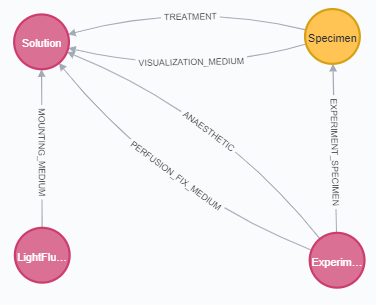

It is interesting to observe them separately. To do this, we need separat projections, only including one of the relationships at a time, and to measure what we create two projections:
- one where only Anaesthetic is included
- one where only Perfusion fix medium is included
- one where only visualization medium is included

In [58]:
with driver.session() as session:
    session.run("""
        CALL gds.graph.create.cypher(
            "anaesthetics", 
            "MATCH (n) return id(n) as id", 
            "MATCH (a)-[r]->(b) WHERE type(r)<>'PERFUSION_FIX_MEDIUM' AND type(r)<>'TREATMENT' AND type(r)<>'VISULIZATION_MEDIUM' AND type(r)<>'MOUNTING_MEDIUM' RETURN id(a) AS source, id(b) AS target"
        )
    """)
                
    session.run("""
        CALL gds.graph.create.cypher(
            "perfusion-fix", 
            "MATCH (n) return id(n) as id", 
            "MATCH (a)-[r]->(b) WHERE type(r)<>'ANAESTHETIC' AND type(r)<>'TREATMENT' AND type(r)<>'VISULIZATION_MEDIUM' AND type(r)<>'MOUNTING_MEDIUM' RETURN id(a) AS source, id(b) AS target"
        )
    """)
                
                
    session.run("""
        CALL gds.graph.create.cypher(
            "visualization-method", 
             "MATCH (n) return id(n) as id", 
            "MATCH (a)-[r]->(b) WHERE type(r)<>'ANAESTHETIC' AND type(r)<>'TREATMENT' AND type(r)<>'PERFUSION_FIX_MEDIUM' AND type(r)<>'MOUNTING_MEDIUM' RETURN id(a) AS source, id(b) AS target"
        )
    """)

In [59]:
import pandas as pd

label_prop_table = []
with driver.session() as session:
    res = session.run("""
        CALL gds.pageRank.stream('anaesthetics')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).name AS name, labels(gds.util.asNode(nodeId))[0] as label, score
        ORDER BY score DESC
    """)
    
    for rec in res:
        label_prop_table.append([rec["name"], rec["label"], rec["score"]])

df = pd.DataFrame(label_prop_table, columns=["Name", "Label", "Page Rank Score"])
df.loc[df["Label"] == "Solution"].head(4)

,Name,Label,Page Rank Score
68,Sodium pentobarbitone,Solution,2.569385
73,Unspecified,Solution,2.297328
162,Ketamine-xylacine,Solution,1.241465
179,Chloral hydrate,Solution,1.080898


In [60]:
import pandas as pd

label_prop_table = []
with driver.session() as session:
    res = session.run("""
        CALL gds.pageRank.stream('perfusion-fix')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).name AS name, labels(gds.util.asNode(nodeId))[0] as label, score
        ORDER BY score DESC
    """)
    
    for rec in res:
        label_prop_table.append([rec["name"], rec["label"], rec["score"]])

df = pd.DataFrame(label_prop_table, columns=["Name", "Label", "Page Rank Score"])
df.loc[df["Label"] == "Solution"].head(4)

,Name,Label,Page Rank Score
26,Paraformaldehyde,Solution,5.853241
113,Paraformaldehyde-glutaraldehyde,Solution,1.547687
210,Biocytin,Solution,0.897844
291,Unspecified,Solution,0.661041


In [61]:
import pandas as pd

label_prop_table = []
with driver.session() as session:
    res = session.run("""
        CALL gds.pageRank.stream('visualization-method')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).name AS name, labels(gds.util.asNode(nodeId))[0] as label, score
        ORDER BY score DESC
    """)
    
    for rec in res:
        label_prop_table.append([rec["name"], rec["label"], rec["score"]])

pd.DataFrame(label_prop_table, columns=["Name", "Label", "Page Rank Score"])
df = pd.DataFrame(label_prop_table, columns=["Name", "Label", "Page Rank Score"])
df.loc[df["Label"] == "Solution"].head(4)

,Name,Label,Page Rank Score
208,Biocytin,Solution,0.924018
448,Neurobiotin,Solution,0.467573
453,DiI particles,Solution,0.461095
465,PalGFP-Sindbis virus,Solution,0.450005


In [62]:
with driver.session() as session:
    session.run("CALL gds.graph.drop('anaesthetics')")
    session.run("CALL gds.graph.drop('perfusion-fix')")
    session.run("CALL gds.graph.drop('visualization-method')")

#### Specimin findings

"Male” is the most influential sex. Both for Rat and Mouse

In [63]:
all_page_rank.loc[all_page_rank["Label"] == "Sex"]

,Name,Label,Page Rank Score
20,Male,Sex,7.240610
116,Female,Sex,1.630765
163,Both,Sex,1.333344


“Adult” is the age category, most often used, both for Rat and Mouse.

In [64]:
all_page_rank.loc[all_page_rank["Label"] == "AgeCategory"].head(4)

,Name,Label,Page Rank Score
32,Adult,AgeCategory,4.653284
33,Adult,AgeCategory,4.624870
314,Juvenile,AgeCategory,0.690787
448,Adolescent,AgeCategory,0.509559


Most influential strain: Wistar for rats, C57BL/6 for mice

In [65]:
all_page_rank.loc[all_page_rank["Label"] == "Strain"].head(4)

,Name,Label,Page Rank Score
7,Wistar,Strain,15.444187
13,C57BL/6,Strain,9.820795
15,Sprague-Dawley,Strain,9.279907
233,Recombinant inbred mouse strain,Strain,0.938945


### Betweenness Centrality

Another centrality measure is the betweenness centrality. Instead of measuring the nodes' direct influence, it measures the nodes' influence in the graph's information flow. Betweenness centrality measures to what extent a node lies on the path between other nodes.

Neo4j's implementation uses Brandes' approximation of the betweenness centrality

In [68]:
import pandas as pd

label_prop_table = []
with driver.session() as session:
    new_call = """
        CALL gds.betweenness.stream('all-nodes')
        YIELD nodeId, score
        RETURN nodeId, gds.util.asNode(nodeId).name AS name, labels(gds.util.asNode(nodeId))[0] AS label, score
        ORDER BY score DESC
    """
    ## The sandbox database is not updated with newest production ready algorithms so we call the old way
    old_call = """
        CALL gds.alpha.betweenness.sampled.stream('all-nodes')
        YIELD nodeId, centrality
        RETURN nodeId, gds.util.asNode(nodeId).name AS name, labels(gds.util.asNode(nodeId))[0] AS label, centrality as score
        ORDER BY centrality DESC
    """
    res = session.run(old_call)
    
    
    for rec in res:
        label_prop_table.append([rec["nodeId"], rec["name"], rec["label"], rec["score"]])

pd.DataFrame(label_prop_table, columns=["NodeId", "Name", "Label", "Betweenness Score"])

,NodeId,Name,Label,Betweenness Score
0,7808,Caudoputamen,BrainRegion,101015.600984
1,9997,Neurons,NeuralStructure,69920.418803
2,7809,Caudoputamen,BrainRegion,46896.239966
3,8092,Striatum,BrainRegion,29233.934401
4,7813,Pars compacta,BrainRegion,22606.337031
...,...,...,...,...
6309,14426,Central nucleus of amygdala lateral part,BamsRegion,0.000000
6310,14427,Dorsal auditory areas,BamsRegion,0.000000
6311,14430,Ectorhinal area,BamsRegion,0.000000
6312,14434,Globus pallidus external segment,BamsRegion,0.000000


We observe from this that the most influential brain regions, found by PageRank, are still the most influention.

Let's look at the top 10, excluding the brain region and neural structures:

In [69]:
_.loc[(_["Label"] != "BrainRegion") & (_["Label"] != "NeuralStructure")].head(10)

,NodeId,Name,Label,Betweenness Score
5,14038,Rostral,RegionZone,21753.556110
6,9905,Neuron,CellType,19990.135473
10,9865,Medium spiny neuron,CellType,11955.241561
11,14047,Central,RegionZone,11017.689008
13,3827,C57BL/6,Strain,7753.730769
14,9960,Dopaminergic neuron,CellType,7520.278942
15,14034,Dorsolateral,RegionZone,7516.022846
16,14036,Dorsomedial,RegionZone,7397.417457
17,9866,Tyrosine hydroxylase expressing,CellType,7363.205748
18,14039,Caudal,RegionZone,7037.620501


Here, we observe that the region-zones are influential and still the same cell types as from page rank. Region-zones might be more influential here as they are in the path between quantitations and brain regions. This can easily be the shortest path as the other step is through a region record. They are at least equal. 
However, not too interesting.

## Similarity algorithms

The final group of graph algorithms presented in this thesis is similarity algorithms. These algorithms measure the similarity of nodes by comparing node pairs

### Node similarity 

An intuitive similarity algorithm is the node similarity algorithm. This algorithm compares two nodes based on their neighboring nodes. In this algorithm, nodes receive a high similarity score if they connect to many of the same nodes. Node similarity defines the similarity of node _i_ and _j_ as the number of neighbor nodes common for _i_ and _j_, divided by the number of distinct neighbor nodes of _i_ and _j_. This measure is called the **Jaccard coefficient**.

In [80]:
import pandas as pd

label_prop_table = []
with driver.session() as session:
    res = session.run("""
        CALL gds.nodeSimilarity.stream(
          'all-nodes',
          {
            degreeCutoff: 1,
            similarityCutoff: 0.5,
            topK: 5
          }
        )
        YIELD node1, node2, similarity
        RETURN gds.util.asNode(node1).name as node1, labels(gds.util.asNode(node1))[0] as node1Label, gds.util.asNode(node2).name as node2, labels(gds.util.asNode(node2))[0] as node2Label, similarity
        ORDER BY similarity DESC
    """)
    
    for rec in res:
        label_prop_table.append([rec["node1"], rec["node1Label"], rec["node2"], rec["node2Label"], rec["similarity"]])

pd.DataFrame(label_prop_table, columns=["node1", "node1Label", "node2", "node2Label", "Similarity"])

,node1,node1Label,node2,node2Label,Similarity
0,Interfascicular nucleus raphe,BamsRegion,Retrorubral area,BamsRegion,1.0
1,Interfascicular nucleus raphe,BamsRegion,Rostral linear nucleus raphe,BamsRegion,1.0
2,Interfascicular nucleus raphe,BamsRegion,Central linear nucleus raphe,BamsRegion,1.0
3,Interfascicular nucleus raphe,BamsRegion,Pedunculopontine nucleus,BamsRegion,1.0
4,Lateral hypothalamic area juxtaparaventricular...,BamsRegion,Dorsal premammillary nucleus,BamsRegion,1.0
...,...,...,...,...,...
16047,Dorsal nucleus raphe,BamsRegion,Nucleus incertus diffuse part,BamsRegion,0.5
16048,Dorsal nucleus raphe,BamsRegion,Nucleus incertus compact part,BamsRegion,0.5
16049,Dorsal premammillary nucleus,BamsRegion,Posterior hypothalamic nucleus,BamsRegion,0.5
16050,Globus pallidus,BamsRegion,Globus pallidus internal segment,BamsRegion,0.5


Let's store the result in a csv and investigate the top 20.

In [81]:
_.to_csv("..\Data/csvs/graphAnalysis/node_similarity_all_nodes.csv")
node_similarity = _
_.head(10)

,node1,node1Label,node2,node2Label,Similarity
0,Interfascicular nucleus raphe,BamsRegion,Retrorubral area,BamsRegion,1.0
1,Interfascicular nucleus raphe,BamsRegion,Rostral linear nucleus raphe,BamsRegion,1.0
2,Interfascicular nucleus raphe,BamsRegion,Central linear nucleus raphe,BamsRegion,1.0
3,Interfascicular nucleus raphe,BamsRegion,Pedunculopontine nucleus,BamsRegion,1.0
4,Lateral hypothalamic area juxtaparaventricular...,BamsRegion,Dorsal premammillary nucleus,BamsRegion,1.0
5,Lateral hypothalamic area juxtaparaventricular...,BamsRegion,Tuberomammillary nucleus,BamsRegion,1.0
6,Lateral hypothalamic area suprafornical region,BamsRegion,Lateral preoptic area,BamsRegion,1.0
7,Lateral nucleus of the amygdala,BamsRegion,Basolateral nucleus of the amygdala,BamsRegion,1.0
8,Lateral preoptic area,BamsRegion,Lateral hypothalamic area suprafornical region,BamsRegion,1.0
9,Medial preoptic area,BamsRegion,Medial preoptic nucleus,BamsRegion,1.0


All natural similarities

In [73]:
node_similarity.loc[node_similarity["node1Label"]== "BrainRegion"].head(5)

,node1,node1Label,node2,node2Label,Similarity
1052,Internal segment,BrainRegion,External segment,BrainRegion,1.0
1053,External segment,BrainRegion,Internal segment,BrainRegion,1.0
2101,Pallidum,BrainRegion,Ventral tegmental area,BrainRegion,1.0
2102,Ventral tegmental area,BrainRegion,Pallidum,BrainRegion,1.0
2103,"Globus pallidus external segment, medial part",BrainRegion,"Globus pallidus external, lateral part",BrainRegion,1.0


In [74]:
node_similarity.loc[node_similarity["node1Label"]== "CellType"].head(5)

,node1,node1Label,node2,node2Label,Similarity
1054,Low huntingtin expressing/calbindin expressing,CellType,Strong huntingtin expressing/calbindin expressing,CellType,1.0
1055,Low huntingtin expressing/calbindin expressing,CellType,Moderate huntingtin expressing/calbindin expre...,CellType,1.0
1056,Moderate huntingtin expressing/calbindin expre...,CellType,Strong huntingtin expressing/calbindin expressing,CellType,1.0
1057,Moderate huntingtin expressing/calbindin expre...,CellType,Low huntingtin expressing/calbindin expressing,CellType,1.0
1058,Strong huntingtin expressing/calbindin expressing,CellType,Moderate huntingtin expressing/calbindin expre...,CellType,1.0


In [76]:
node_similarity.loc[node_similarity["node1Label"]== "NeuralStructure"].head(5)

,node1,node1Label,node2,node2Label,Similarity
6747,Synapses,NeuralStructure,"Synapses, symmetrical",NeuralStructure,0.5
6748,"Synapses, symmetrical",NeuralStructure,"Synapses, asymmetrical",NeuralStructure,0.5
6749,"Synapses, symmetrical",NeuralStructure,Synapses,NeuralStructure,0.5
6750,"Synapses, asymmetrical",NeuralStructure,"Synapses, symmetrical",NeuralStructure,0.5


In [83]:
node_similarity.loc[node_similarity["node1Label"]== "Solution"].head(5)

,node1,node1Label,node2,node2Label,Similarity


In [84]:
node_similarity.loc[node_similarity["node1Label"]== "Reporter"].head(5)

,node1,node1Label,node2,node2Label,Similarity
3511,Unspecified anti D1A,Reporter,Rabbit anti D1,Reporter,1.0
3512,Unspecified anti D1A,Reporter,Rat anti dopamine 1 receptor,Reporter,1.0
3513,Unspecified anti D1A,Reporter,Rat anti dopamine 1 receptor,Reporter,1.0
3514,Unspecified anti D2,Reporter,Goat anti D2R,Reporter,1.0
3515,Unspecified anti D2,Reporter,Rabbit anti dopamine 2 receptor,Reporter,1.0


### Similarity of analyses

For similarities we are also interested in observing similarities between *analyses* specifically. 

First, we had a specific use case for the website: The notebook `/2. Extending the data with extracted information - GraphAnalysis/3. UseCases.ipynb` presents a the similarity measure between analyses that is used on the website. 
This is specific to the analyses matching on cell type, region and specie. By this the analyses need a similarity score of 1.0 to be measured there.

However, we are also interested in observing if there are any unpredicted similarity between the analyses based on all the other methodologies connected to the analyses nodes. By this, we present these efforts below

First, we list out the analysis similarities from the algorithm run above

In [85]:
node_similarity.loc[node_similarity["node1Label"]== "Analysis"].head(10)

,node1,node1Label,node2,node2Label,Similarity
11036,Wang_2007_sections_SP/ENK_neurons_patch_quanti...,Analysis,Wang_2007_sections_SP/ENK_neuron_matrix_quanti...,Analysis,0.882353
11037,Wang_2007_sections_SP/ENK_neuron_matrix_quanti...,Analysis,Wang_2007_sections_SP/ENK_neurons_patch_quanti...,Analysis,0.882353
11084,Baquet_2009_sections_recon_TH_neurons_quantita...,Analysis,Baquet_2009_sections_recon-2D_TH_neurons_distr...,Analysis,0.833333
11085,Baquet_2009_sections_recon-2D_TH_neurons_distr...,Analysis,Baquet_2009_sections_recon_TH_neurons_quantita...,Analysis,0.833333
11229,McNeill_1990_10m_sections_TH_neurons_quantitation,Analysis,McNeill_1990_10m_sections_TH_neurons_quantitat...,Analysis,0.818182
11230,McNeill_1990_3m_sections_TH_neurons_quantitation,Analysis,McNeill_1990_3m_sections_TH_neurons_quantitati...,Analysis,0.818182
11231,McNeill_1990_3m_sections_TH_neurons_quantitati...,Analysis,McNeill_1990_3m_sections_TH_neurons_quantitation,Analysis,0.818182
11232,McNeill_1990_10m_sections_TH_neurons_quantitat...,Analysis,McNeill_1990_10m_sections_TH_neurons_quantitation,Analysis,0.818182
11233,Saylor_2006_sections_proximal_spines_quantitation,Analysis,Saylor_2006_sections_all_spines_quantitation,Analysis,0.818182
11234,Saylor_2006_sections_proximal_spines_quantitation,Analysis,Saylor_2006_sections_distal_spines_quantitation,Analysis,0.818182


Here, we observe the pattern that analysis from the same experiment are similar to each other. Is there a way to move beyond this and only observe the similar analysis from the same experiment?

In [86]:
def get_name(analysis_name):
    return analysis_name.str.split("_").str[:2]

similar_analyses = node_similarity.loc[(node_similarity["node1Label"]== "Analysis")].sort_values(["Similarity", "node1"], ascending=[False, True])
similar_analyses.loc[(get_name(similar_analyses["node1"]) != get_name(similar_analyses["node2"]) )]

,node1,node1Label,node2,node2Label,Similarity
13865,Chalimoniuk_2006_TH_sections_neurons_quantitation,Analysis,Vidyadhara_2017_F1-1_sections_TH_neurons_quant...,Analysis,0.555556
13866,Chalimoniuk_2006_TH_sections_neurons_quantitation,Analysis,Vidyadhara_2017_cd1_sections_th_neurons_quanti...,Analysis,0.555556
13867,Chalimoniuk_2006_TH_sections_neurons_quantitation,Analysis,Vidyadhara_2017_c57bl/6_sections_th_neurons_qu...,Analysis,0.555556
13883,Lauber_2016_sections_PV_neurons_quantitation,Analysis,Lauber_2018_sections_PV_neurons_quantitation,Analysis,0.555556
13882,Lauber_2016_sections_VVA_neurons_quantitation,Analysis,Lauber_2018_sections_VVA_quantitation,Analysis,0.555556
13880,Lauber_2018_sections_PV_neurons_quantitation,Analysis,Lauber_2016_sections_PV_neurons_quantitation,Analysis,0.555556
13881,Lauber_2018_sections_VVA_quantitation,Analysis,Lauber_2016_sections_VVA_neurons_quantitation,Analysis,0.555556
13864,Vidyadhara_2017_F1-1_sections_TH_neurons_quant...,Analysis,Chalimoniuk_2006_TH_sections_neurons_quantitation,Analysis,0.555556
13862,Vidyadhara_2017_c57bl/6_sections_th_neurons_qu...,Analysis,Chalimoniuk_2006_TH_sections_neurons_quantitation,Analysis,0.555556
13863,Vidyadhara_2017_cd1_sections_th_neurons_quanti...,Analysis,Chalimoniuk_2006_TH_sections_neurons_quantitation,Analysis,0.555556


These are all analyses that are similar (only by approxmately 50 percent) and are not from the same experiment.

#### Specific analysis nodes
There are not all nodes that the analyses are connected too that are equally relevant. So we can create a projection with the desired nodes and relationships and run the same analysis again:

We are interested in the following:
- CellType, Brain Region and Neural Structure
- The data type
- Sectioning Instrument
- Reporter
- Microscope
- Specie

Some of these relationships does not exist. So we create them before making the projection: In addition we need to create a node that specifies the data type:

In [87]:
with driver.session() as session: ## TODO add specific relation to all so only analyses are compared, no interlinked relationshipsss
    ## data types
    session.run("CREATE (:AnalysisDataType {id: 1, name: 'Quantitation'})")
    session.run("CREATE (:AnalysisDataType {id: 2, name: 'Distribution'})")
    session.run("CREATE (:AnalysisDataType {id: 3, name: 'Morphology'})")
    
    session.run("""
        MATCH (n:Analysis)
        MATCH (m:AnalysisDataType)
        WHERE n.dataType = m.name
        MERGE (n)-[:NODE_SIMILARITY]->(m)
    """)
    ## brain region
    session.run("""
        MATCH (n:Analysis)-->(:DataType)-->(:RegionRecord)-[:PRIMARY_REGION]->(b:BrainRegion)
        MERGE (n)-[:NODE_SIMILARITY]->(b)
    """)
    ## Specie
    session.run("""
        MATCH (n:Analysis)-->(:Specimen)-->(s:Specie)
        MERGE (n)-[:NODE_SIMILARITY]->(s)
    """)
    ## Microscope
    session.run("""
        MATCH (n:Analysis)-->()-->(m:Microscope)
        MERGE (n)-[:NODE_SIMILARITY]->(m)
    """)
    ## Reporter
    session.run("""
        MATCH (n:Analysis)-->(:ReporterIncubation)-->(r:Reporter)
        MERGE (n)-[:NODE_SIMILARITY {strength: 1}]->(r)
    """)
    ## CellularRegion
    session.run("""
        MATCH (n:Analysis)-->(:DataType)-->(r:CellularRegion)
        MERGE (n)-[:NODE_SIMILARITY]->(r)
    """)
    ## Software
    session.run("""
        MATCH (n:Analysis)-->(:DataType)-->(s:Software)
        MERGE (n)-[:NODE_SIMILARITY]->(s)
    """)
    ## RegionZone
    session.run("""
        MATCH (n:Analysis)-->(:DataType)-->(s:RegionZone)
        MERGE (n)-[:NODE_SIMILARITY]->(s)
    """)
    ## SectioningInstrument
    session.run("""
        MATCH (n:Analysis)-->(s:SectioningInstrument)
        MERGE (n)-[:NODE_SIMILARITY]->(s)
    """)

     ## CellType
    session.run("""
        MATCH (n:Analysis)-->(c:CellType)
        MERGE (n)-[:NODE_SIMILARITY]->(c)
    """)


Then we can create the projection

In [88]:
with driver.session() as session:
    ## WHat if I only add all nodes and the relationship NODE_SIMILARITY? Than relationships dont count twice :D 
    res = session.run("""
        CALL gds.graph.create(
            'analyses', 
            ["CellType", "CellularRegion", "NeuralStructure", "Analysis", "SectioningInstrument", "Reporter","VisualizationProtocol", "AnalysisDataType", "Microscope", "Software", "BrainRegion", "IntroductionType", "IntroductionTiming", "TreatmentPurpose"], 
            'NODE_SIMILARITY'
        )
    """)
    for rec in res:
        print("Created projection with", rec["nodeCount"], "nodes, and", rec["relationshipCount"], "relationships")

Created projection with 1257 nodes, and 3831 relationships


In [89]:
import pandas as pd

analysis_similarity_table = []
with driver.session() as session:
    res = session.run("""
        CALL gds.nodeSimilarity.stream(
          'analyses',
          {
            degreeCutoff: 3,
            similarityCutoff: 0.5,
            topK: 2
          }
        )
        YIELD node1, node2, similarity
        RETURN gds.util.asNode(node1).name as node1, labels(gds.util.asNode(node1))[0] as node1Label, gds.util.asNode(node2).name as node2, labels(gds.util.asNode(node2))[0] as node2Label, similarity
        ORDER BY similarity DESC
    """)
    
    for rec in res:
        analysis_similarity_table.append([rec["node1"], rec["node1Label"], rec["node2"], rec["node2Label"], rec["similarity"]])

analysis_similarity = pd.DataFrame(analysis_similarity_table, columns=["node1", "node1Label", "node2", "node2Label", "Similarity"])

def get_name(analysis_name):
    return analysis_name.str.split("_").str[:2]

similar_analyses = analysis_similarity.loc[(analysis_similarity["node1Label"]== "Analysis")].sort_values(["Similarity", "node1"], ascending=[False, True])
similar_analyses.loc[(get_name(similar_analyses["node1"]) != get_name(similar_analyses["node2"]) )]

,node1,node1Label,node2,node2Label,Similarity
385,Andreassen_2000_sections_ppSS_neurons_quantita...,Analysis,Salin_1990_sections_som_neurons_quantitation,Analysis,1.0
386,Antzoulatos_2011_sections_spines_quantitation,Analysis,Fogarty_2017_young_slices_MSN_spines_quantitation,Analysis,1.0
387,Antzoulatos_2011_sections_spines_quantitation,Analysis,Fogarty_2017_old_slices_MSN_spines_quantitation,Analysis,1.0
26,Baker_1980_BALB/cJ_sections_neuron_quantitation,Analysis,Dodds_2014_sections_neurons_quantitation,Analysis,1.0
28,Baker_1980_CBA/J_sections_neuron_quantitation,Analysis,Dodds_2014_sections_neurons_quantitation,Analysis,1.0
...,...,...,...,...,...
1277,Svingos_1999_ultrathin_KOR_terminals_quantitation,Analysis,Pickel_1998_sections_NPY_axonterminals_quantit...,Analysis,0.5
1279,Talavera_1997_mountedsections_weak_NADPHd_neur...,Analysis,West_1996_mounted_somatostatin_neurons_quantit...,Analysis,0.5
1306,Uehara-Kunugi_1991_sections_nadph_neurons_quan...,Analysis,Lenz_1994_sections_PV_GAD67_neurons_quantitation,Analysis,0.5
1282,Yang_2008_sections_XPA_cells_quantitation,Analysis,Ishida_2001_sections_TH_neurons_quantitation,Analysis,0.5


In [90]:
similar_analyses.to_csv("..\Data/csvs/graphAnalysis/node_similarity_analyses.csv")

Finally, we clean up:

In [91]:
with driver.session() as session:
    session.run("""
        MATCH ()-[r:NODE_SIMILARITY]-()
        DETACH DELETE r
    """)
    session.run("""
        MATCH (n:AnalysisDataType)
        DETACH DELETE n
    """)
    session.run("CALL gds.graph.drop('analyses')")

## Clean-up

Remove graph projections from database

In [92]:
with driver.session() as session:
    session.run("CALL gds.graph.drop('all-nodes')")